# Hiding Future Tokens with Causal or Masked Attention

In causal or masked attention, the attention weights above the diagonal are masked.



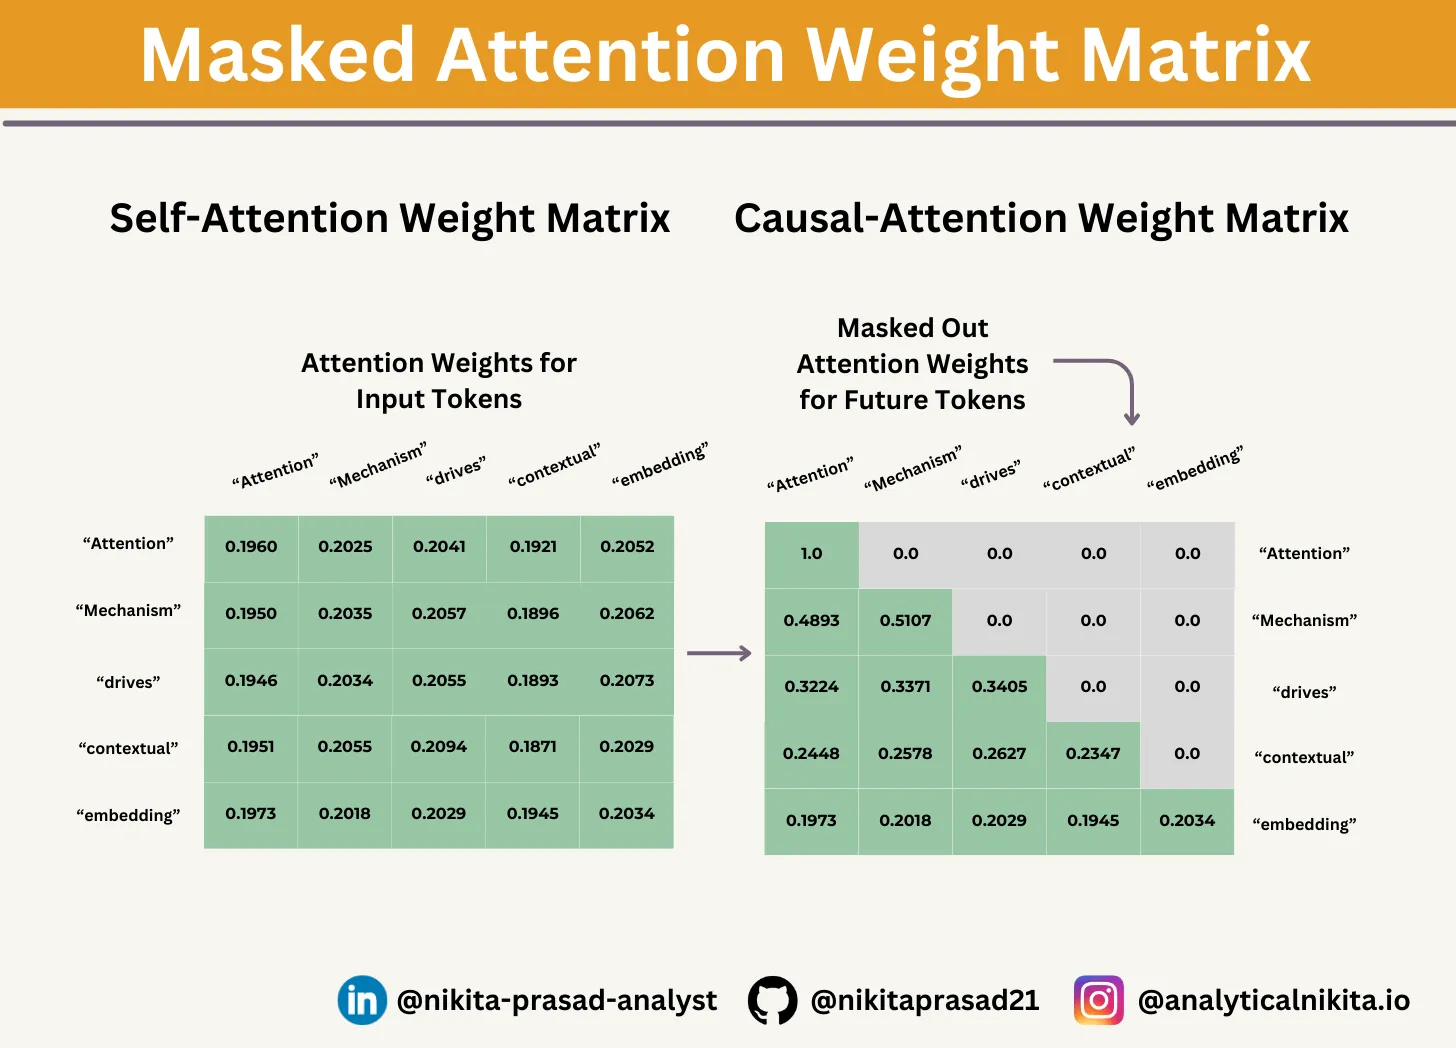

To ensure that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight

<div class="alert alert-block alert-success">

Let's work with the attention scores and weights from the [***Self-Attention Mechanism***](https://github.com/nikitaprasad21/LLM-Cheat-Code/blob/main/Attention-Mechanism/Self_Attention_Mechanism.ipynb) to code the Causal Attention Mechanism.
    
</div>

In [ ]:
import torch

input_emb = torch.tensor([
    [0.12, 0.45, 0.67],  # "Attention"
    [0.34, 0.56, 0.78],  # "Mechanism"
    [0.23, 0.57, 0.91],  # "drives"
    [0.76, 0.88, 0.45],  # "contextual"
    [0.54, 0.12, 0.34]   # "embedding"
], dtype=torch.float32)

In [ ]:
d_in = input_emb.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

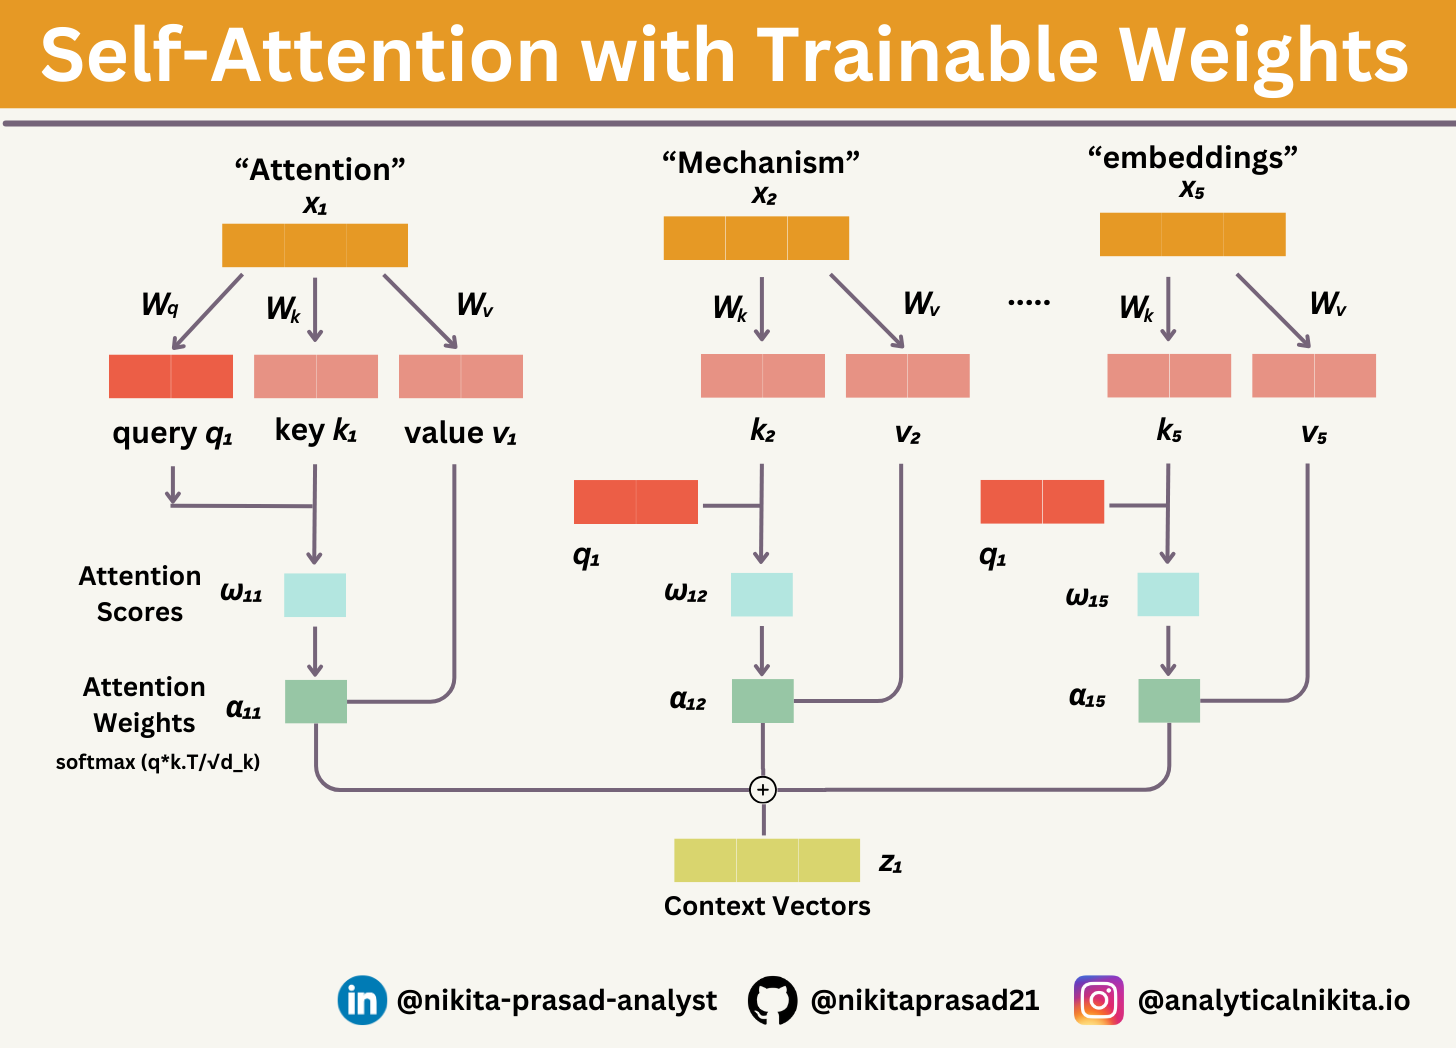

In [ ]:
import torch.nn as nn

class SelfAttention(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa = SelfAttention(d_in, d_out)
print(sa(input_emb))

tensor([[-0.0962,  0.0331],
        [-0.0964,  0.0326],
        [-0.0962,  0.0328],
        [-0.0975,  0.0309],
        [-0.0962,  0.0333]], grad_fn=<MmBackward0>)


In [ ]:
# Reuse the query and key weight matrices of the SelfAttention_v2 object from the previous section
queries = sa.W_query(input_emb)
keys = sa.W_key(input_emb)
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1960, 0.2025, 0.2041, 0.1921, 0.2052],
        [0.1950, 0.2035, 0.2057, 0.1896, 0.2062],
        [0.1946, 0.2034, 0.2055, 0.1893, 0.2073],
        [0.1951, 0.2055, 0.2094, 0.1871, 0.2029],
        [0.1973, 0.2018, 0.2029, 0.1945, 0.2034]], grad_fn=<SoftmaxBackward0>)


<div class="alert alert-block alert-success">

We can now use PyTorch's tril function to create a mask
where the values above the diagonal are zero:

</div>

In [ ]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


Now, we can multiply this mask with the attention weights to zero out the values above the diagonal:

In [ ]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1960, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1950, 0.2035, 0.0000, 0.0000, 0.0000],
        [0.1946, 0.2034, 0.2055, 0.0000, 0.0000],
        [0.1951, 0.2055, 0.2094, 0.1871, 0.0000],
        [0.1973, 0.2018, 0.2029, 0.1945, 0.2034]], grad_fn=<MulBackward0>)


As we can see, the elements above the diagonal are successfully zeroed out

The 3rd step is to renormalize the attention weights to sum up to 1 again in each row.

We can achieve this by dividing each element in each row by the sum in each row:

In [ ]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4893, 0.5107, 0.0000, 0.0000, 0.0000],
        [0.3224, 0.3371, 0.3405, 0.0000, 0.0000],
        [0.2448, 0.2578, 0.2627, 0.2347, 0.0000],
        [0.1973, 0.2018, 0.2029, 0.1945, 0.2034]], grad_fn=<DivBackward0>)


<div class="alert alert-block alert-info">

The result is an attention weight matrix where the attention weights above the diagonal are
zeroed out and where the rows sum to 1.

</div>



While we could be technically done with implementing causal attention at this point, we can
take advantage of a mathematical property of the softmax function.


However, if the mask were applied after softmax, like above, it would disrupt the probability distribution created by softmax.

Softmax ensures that all output values sum to 1.

Masking after softmax would require re-normalizing the outputs to sum to 1 again, which complicates the process and might lead to unintended effects.



Alternatively, there's a more efficient approach to achieve this.

Instead of zeroing out attention weights above the diagonal and renormalizing the results.

We can mask the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function.



The softmax function converts its inputs into a probability distribution.

When negative
infinity values (-∞) are present in a row, the softmax function treats them as zero
probability.

(Mathematically, this is because e^
-∞ approaches 0.)


We can implement this more efficient masking "trick" by creating a mask with 1's above
the diagonal and then replacing these 1's with negative infinity (-inf) values:



In [ ]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.0988,   -inf,   -inf,   -inf,   -inf],
        [0.1345, 0.1951,   -inf,   -inf,   -inf],
        [0.1330, 0.1957, 0.2100,   -inf,   -inf],
        [0.1985, 0.2716, 0.2985, 0.1392,   -inf],
        [0.0688, 0.1003, 0.1079, 0.0486, 0.1117]],
       grad_fn=<MaskedFillBackward0>)



As we can see below, now the attention weights in each row correctly sum to 1 again:

Now, all we need to do is apply the softmax function to these masked results, and we are done.

In [ ]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4893, 0.5107, 0.0000, 0.0000, 0.0000],
        [0.3224, 0.3371, 0.3405, 0.0000, 0.0000],
        [0.2448, 0.2578, 0.2627, 0.2347, 0.0000],
        [0.1973, 0.2018, 0.2029, 0.1945, 0.2034]], grad_fn=<SoftmaxBackward0>)


As we can see based on the output, the values in each row sum to 1, and no further normalization is necessary.

Masking in Transformers sets scores for future tokens to a large negative value, making their influence in the softmax calculation effectively zero.

The softmax function then recalculates attention weights only among the unmasked tokens.

This process ensures no information leakage from masked tokens, focusing the model solely on the intended data.

We could now use the modified attention weights to compute the context vectors via `context_vec = attn_weights @ values`.

However, in the next section, we first cover another minor tweak to the causal attention mechanism that is useful for reducing overfitting when training LLMs.

## Masking Additional Attention Weights With Dropout

In addition, we also apply dropout to reduce overfitting during training of the LLM.

> Dropout is a DL technique where randomly selected hidden layer units are ignored during the training of the Neural Network for preventing overfitting and improving generalization.

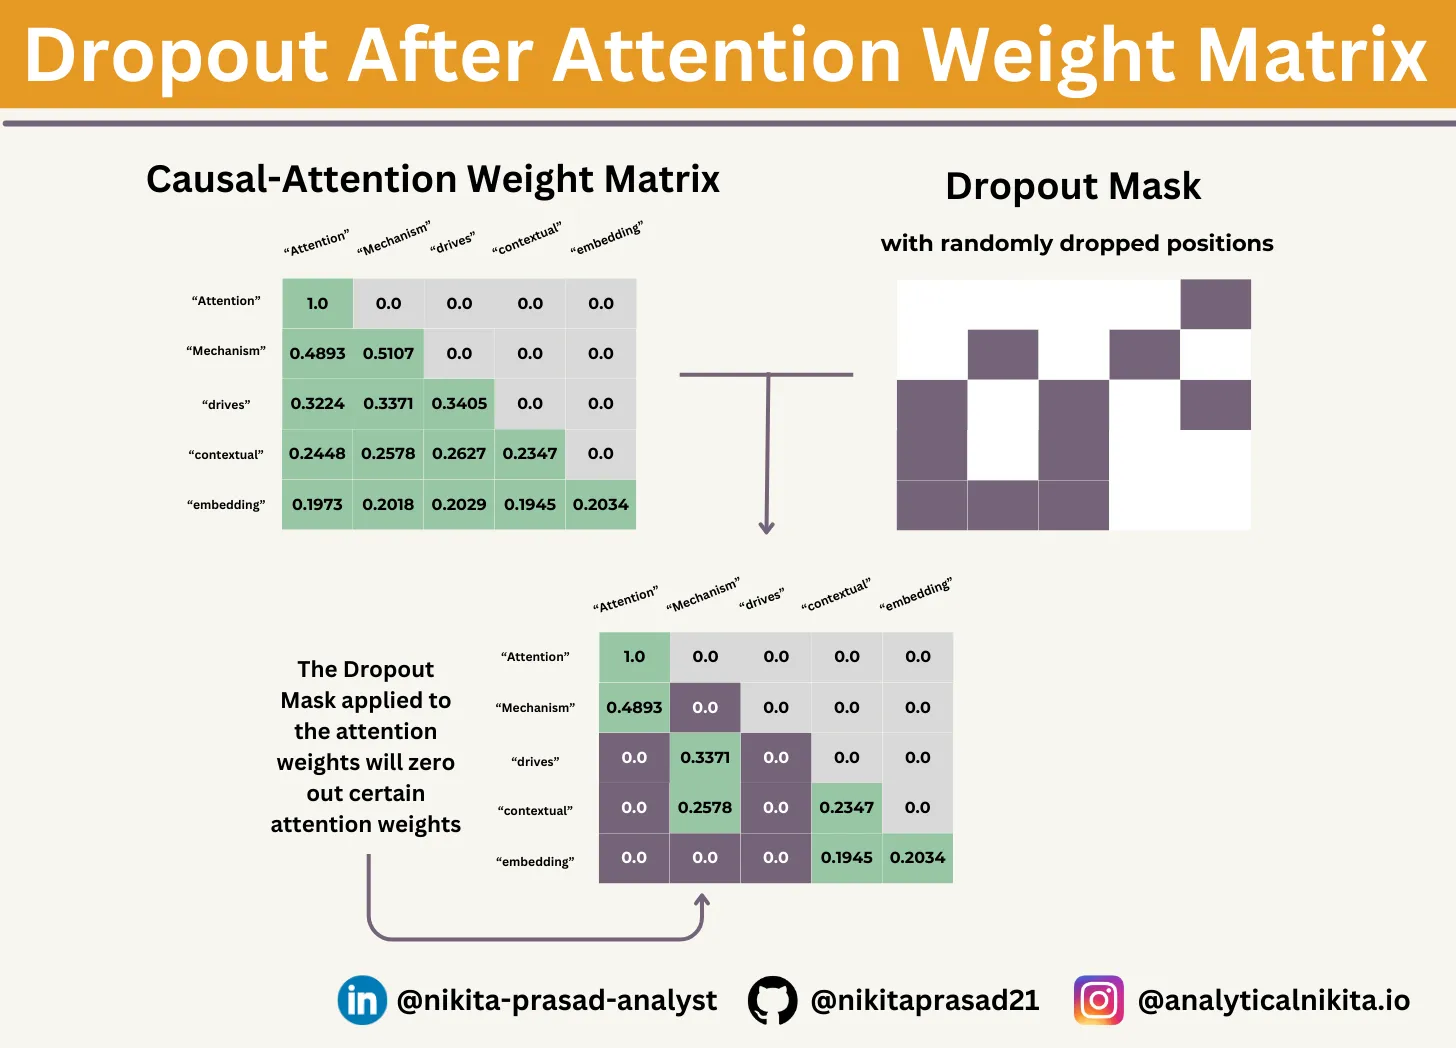

In the following code snippet, we use a dropout rate of 50%, which means masking out
half of the attention weights.



> **Note**: Later, when we train the GPT model, we will use a
lower dropout rate, such as 0.1 or 0.2.





When applying dropout to an attention weight matrix with a rate of 50%, half of the elements in the matrix are randomly set to zero.

To compensate for the reduction in active elements, the values of the remaining elements in the matrix are scaled up by a factor of 1/0.5 = 2.

This scaling is crucial to maintain the overall balance of the attention weights, ensuring that the average influence of the attention mechanism remains consistent during both the training and inference phases.

Now, let's apply dropout to the attention weight matrix itself:




In [ ]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%

In [ ]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9786, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5155, 0.0000, 0.4695, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3891, 0.4069]], grad_fn=<MulBackward0>)


As we can see above, the resulting attention weight matrix now has additional elements zeroed out and the remaining ones rescaled.

Also, let's implement the code to handle batches consisting of more than one input so that our `CausalAttention` class supports the batch outputs produced by the data , that we implemented previously.

For simplicity, to simulate such batch input, we duplicate the input text example:


In [ ]:
batch = torch.stack((input_emb, input_emb), dim=0)
print(batch.shape) # 2 inputs with 5 tokens each, and each token has embedding dimension

torch.Size([2, 5, 3])


This results in a 3D tensor consisting of 2 input texts with 5 tokens each, where each token
is a 3-dimensional embedding vector.
    

##  Implementing Causal Self-Attention class


Now, we are ready to implement a self-attention, including the causal and dropout masks.



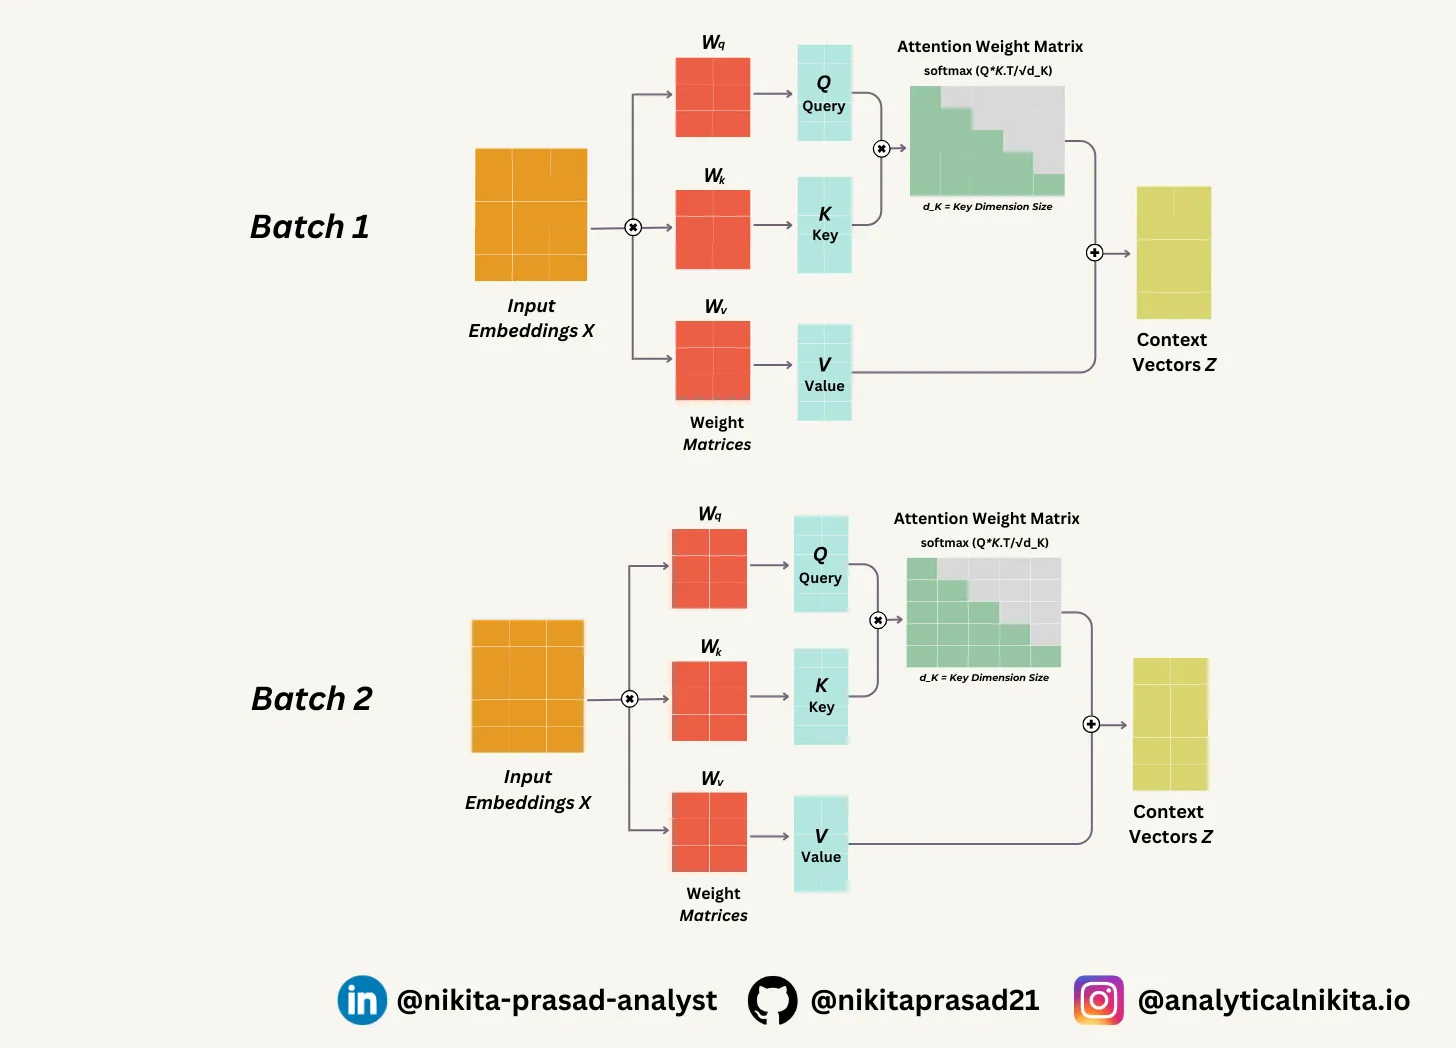



**Step 1**: Compared to the previous SelfAttention class, we added a dropout layer.
    
**Step 2**: The register_buffer call is also a new addition.

**Step 3**:  We transpose dimensions 1 and 2, keeping the batch dimension at the first position (i.e., 0).





In [ ]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape                # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(                    # Note `_` operations are in-place in PyTorch
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec

**Note**: In PyTorch, operations with a trailing underscore are performed in-place, avoiding unnecessary memory
copies

The use of register_buffer in
PyTorch is not strictly necessary for all use cases but offers several advantages here.

For
instance, when we use the CausalAttention class in our LLM, buffers are automatically
moved to the appropriate device (CPU or GPU) along with our model, which will be relevant
when training the LLM in future chapters.

This means we don't need to manually ensure
these tensors are on the same device as your model parameters, avoiding device mismatch
errors.

In [ ]:
print(d_in)
print(d_out)

torch.manual_seed(123)
# Instantiating CausalAttention Class
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

3
2
tensor([[[-0.3585,  0.0415],
         [-0.4451,  0.0252],
         [-0.4656,  0.0393],
         [-0.5461, -0.0500],
         [-0.5129, -0.0367]],

        [[-0.3585,  0.0415],
         [-0.4451,  0.0252],
         [-0.4656,  0.0393],
         [-0.5461, -0.0500],
         [-0.5129, -0.0367]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 5, 2])



As we can see, the resulting context vector is a 3D tensor where each token is now represented by a 2D
embedding:

**Note**: Dropout is only applied during training, not during inference




> Next we will expand on this concept
and implement a multi-head attention module, that implements several of such causal
attention mechanisms in parallel.


 Stay Tuned! And don't forget to share and star this repository.

